# Read gmsh file

In [223]:
# import 
import toughio 
import numpy as np
import meshio
import torch

In [224]:
filename='./square.msh'
mesh = toughio.read_mesh(filename)

In [225]:
mesh1=meshio.read(filename)

In [226]:
mesh1.cells
type(mesh1)

meshio._mesh.Mesh

In [227]:
# mesh info
nele = mesh.n_cells
cubic = True
if (cubic) :
    nloc = 10 
    ngi = 13
nonods = nloc*nele 
ndim = 2
ndglno=np.arange(0,nonods)
print(mesh.cells[0][1]) # cell node list
mesh.points

[[ 4  0  9]
 [ 0  6  9]
 [ 1  5 10]
 [ 6  1 10]
 [ 5  2 12]
 [ 2  7 12]
 [ 3  4 11]
 [ 7  3 11]
 [ 4  9 11]
 [ 5  8 10]
 [ 8  5 12]
 [ 6  8  9]
 [ 8  6 10]
 [ 8  7 11]
 [ 7  8 12]
 [ 9  8 11]]


array([[0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [1.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.  ],
       [0.5 , 1.  , 0.  ],
       [0.  , 0.5 , 0.  ],
       [1.  , 0.5 , 0.  ],
       [0.5 , 0.5 , 0.  ],
       [0.25, 0.25, 0.  ],
       [0.25, 0.75, 0.  ],
       [0.75, 0.25, 0.  ],
       [0.75, 0.75, 0.  ]])

In [228]:

# create the adjacency matrix to store connections
adjacency_matrix = torch.eye(nonods)

# populate the connections with a one 
for element in mesh.cells[0][1]:
    for i in element:
        for j in element:
            if adjacency_matrix[i][j] != 1:
                adjacency_matrix[i][j] = 1

In [229]:
# create faces
faces=[]

for ele in range(nele):
    element = mesh.cells[0][1][ele]
    for iloc in range(3):
        faces.append([element[iloc],element[(iloc+1)%3]])


In [230]:
# neighbouring elements
nbf=np.empty(len(faces))
nbf[:]=np.nan
color=np.zeros(len(faces))
for iface in range(len(faces)):
    if color[iface]==1 :
        continue 
    for jface in range(iface+1,len(faces)):
        if (color[jface]==1):
            continue 
        elif (set(faces[jface])==set(faces[iface])):
            print(faces[jface],'|',faces[iface])
            if faces[jface][0]==faces[iface][0]:
                nbf[iface]=jface 
                nbf[jface]=iface
            else:
                nbf[iface]=-jface 
                nbf[jface]=-iface
            color[iface]=1
            color[jface]=1
            continue
nbf

[9, 0] | [0, 9]
[4, 9] | [9, 4]
[9, 6] | [6, 9]
[10, 5] | [5, 10]
[1, 10] | [10, 1]
[6, 10] | [10, 6]
[12, 2] | [2, 12]
[5, 12] | [12, 5]
[12, 7] | [7, 12]
[11, 4] | [4, 11]
[3, 11] | [11, 3]
[7, 11] | [11, 7]
[11, 9] | [9, 11]
[8, 5] | [5, 8]
[10, 8] | [8, 10]
[8, 12] | [12, 8]
[8, 6] | [6, 8]
[9, 8] | [8, 9]
[7, 8] | [8, 7]
[8, 11] | [11, 8]


array([ nan,  -5., -24.,  nan, -35.,  -1.,  nan, -29., -10.,  nan,  -8.,
       -37.,  nan, -17., -31.,  nan, -44., -13.,  nan, -26., -22.,  nan,
       -20., -40.,  -2., -47., -19., -30., -38.,  -7., -27., -14., -43.,
       -36., -45.,  -4., -33., -11., -28., -42., -23., -46., -39., -32.,
       -16., -34., -41., -25.])

In [231]:
# find neighbouring elements associated with each face
# via neighbouring faces
# and store in nbele
nbele=np.empty(len(faces))
nbele[:]=np.nan
for iface in range(len(nbf)):
    nbele[iface] = np.sign(nbf[iface])*(np.abs(nbf[iface])//3)
nbele

array([ nan,  -1.,  -8.,  nan, -11.,  -0.,  nan,  -9.,  -3.,  nan,  -2.,
       -12.,  nan,  -5., -10.,  nan, -14.,  -4.,  nan,  -8.,  -7.,  nan,
        -6., -13.,  -0., -15.,  -6., -10., -12.,  -2.,  -9.,  -4., -14.,
       -12., -15.,  -1., -11.,  -3.,  -9., -14.,  -7., -15., -13., -10.,
        -5., -11., -13.,  -8.])

In [232]:
# generate cubic nodes
x_all = []
for ele in range(16):
    # vertex nodes global index
    idx = mesh.cells[0][1][ele]
    # vertex nodes coordinate 
    x_loc=[]
    for id in idx:
        x_loc.append(mesh.points[id])
        # print(x_loc)
    # ! a reference cubic element looks like this:
    # !  y
    # !  | 
    # !  2
    # !  | \
    # !  6  5
    # !  |   \
    # !  7 10 4
    # !  |     \
    # !  3-8-9--1--x
    # nodes 1-3
    x_all.append([x_loc[0][0], x_loc[0][1]])
    x_all.append([x_loc[1][0], x_loc[1][1]])
    x_all.append([x_loc[2][0], x_loc[2][1]])
    # nodes 4,5
    x_all.append([x_loc[0][0]*2./3.+x_loc[1][0]*1./3., x_loc[0][1]*2./3.+x_loc[1][1]*1./3.])
    x_all.append([x_loc[0][0]*1./3.+x_loc[1][0]*2./3., x_loc[0][1]*1./3.+x_loc[1][1]*2./3.])
    # nodes 6,7
    x_all.append([x_loc[1][0]*2./3.+x_loc[2][0]*1./3., x_loc[1][1]*2./3.+x_loc[2][1]*1./3.])
    x_all.append([x_loc[1][0]*1./3.+x_loc[2][0]*2./3., x_loc[1][1]*1./3.+x_loc[2][1]*2./3.])
    # nodes 8,9
    x_all.append([x_loc[2][0]*2./3.+x_loc[0][0]*1./3., x_loc[2][1]*2./3.+x_loc[0][1]*1./3.])
    x_all.append([x_loc[2][0]*1./3.+x_loc[0][0]*2./3., x_loc[2][1]*1./3.+x_loc[0][1]*2./3.])
    # node 10
    x_all.append([(x_loc[0][0]+x_loc[1][0]+x_loc[2][0])/3.,(x_loc[0][1]+x_loc[1][1]+x_loc[2][1])/3.])
# x_all

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]
[50 51 52 53 54 55 56 57 58 59]
[60 61 62 63 64 65 66 67 68 69]
[70 71 72 73 74 75 76 77 78 79]
[80 81 82 83 84 85 86 87 88 89]
[90 91 92 93 94 95 96 97 98 99]
[100 101 102 103 104 105 106 107 108 109]
[110 111 112 113 114 115 116 117 118 119]
[120 121 122 123 124 125 126 127 128 129]
[130 131 132 133 134 135 136 137 138 139]
[140 141 142 143 144 145 146 147 148 149]
[150 151 152 153 154 155 156 157 158 159]


/tmp/ipykernel_1728604/1296823504.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


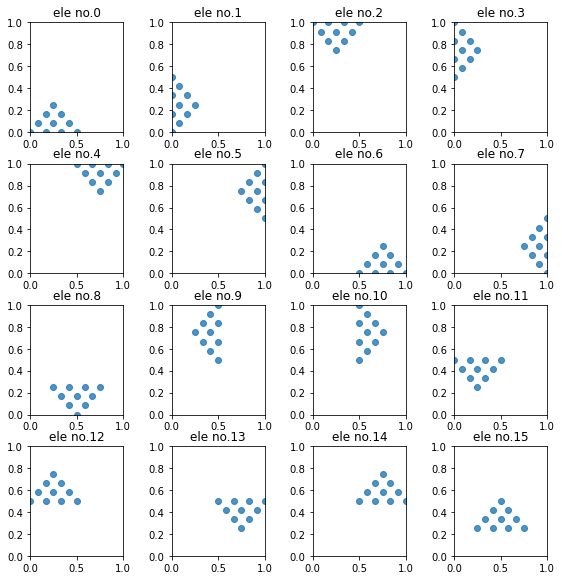

In [233]:
import matplotlib.pyplot as plt 
x_all=np.asarray(x_all)
fig,ax=plt.subplots(4,4, figsize=(8,8))
fig.tight_layout()
ax=ax.flatten()
for ele in range(nele):
    toplt = np.arange((ele)*nloc,(ele)*nloc+nloc)
    print((toplt))
    ax[ele].scatter(x_all[toplt,0],x_all[toplt,1],alpha=0.8)
    ax[ele].title.set_text('ele no.'+str(ele))
    ax[ele].set_xlim([0,1])
    ax[ele].set_ylim([0,1])
fig.show()

In [243]:
def face_iloc(iface):
    # return local nodes number on a face
    match iface:
        case 0:
            return [0,3,4,1]
        case 1:
            return [1,5,6,2]
        case 2:
            return [0,8,7,2]
        case _:
            return []
def face_iloc2(iface):
    # return local nodes number on the other side of a face
    # in reverse order 
    iloc_list=face_iloc(iface)
    iloc_list.reverse()
    return iloc_list

In [240]:
# example
# we're in ele1, assembling face integral, 
# where are S_ij and S_bc_ij located?

# let's omit the relative direction of opposite faces 
# (since gmsh automatically align all faces in opposite 
# direction)
for ele in range(10,16):
    # face 0
    iface = 0
    glbface = iface+ele*3
    ele2 = int(abs(nbele[glbface]))
    glbface2 = int(abs(nbf[glbface]))
    iface2 = glbface2%3

    # face 1
    # face 2



10 9 0 0 30 27
11 12 0 0 33 36
12 11 0 0 36 33
13 14 0 0 39 42
14 13 0 0 42 39
15 11 0 1 45 34
